<a href="https://colab.research.google.com/github/Nyota-Lab/torch/blob/Modelo-de-reconocimiento-de-imagenes/Modelo_de_Clasificacion_de_Im%C3%A1genes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modelo de clasificacion de imagenes
* Vamos a entrenar un modelo de clasificacion de imagenes usando el dataset normalizado

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import utils
from torchvision import datasets
from torchvision import transforms

from PIL import Image
import urllib.request as request
import matplotlib.pyplot as plt

In [2]:
data_path = 'data/'
full_data_set = datasets.CIFAR10(data_path, train=True,download=True, transform=transforms.Compose([
                                                      transforms.ToTensor(),
                                                      transforms.Normalize(
                                                          mean=[0.4915, 0.4823, 0.4468],
                                                          std=[0.2470, 0.2435, 0.2616]
                                                      )]))
full_validation_set = datasets.CIFAR10(data_path, train=False,download=True, transform=transforms.Compose([
                                                      transforms.ToTensor(),
                                                      transforms.Normalize(
                                                          mean=[0.4915, 0.4823, 0.4468],
                                                          std=[0.2470, 0.2435, 0.2616]
                                                      )]))

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


* Vamos a generar un dataloader que nos va a permitir hacer batchs de imagenes de acuerdo a el tamaño que decidamos

In [0]:
size = 4
dataloader = torch.utils.data.DataLoader(full_data_set, batch_size=size, shuffle=True, num_workers=2)

* Una vez tenemos nuestra funcion dataloader vamos a aplicarla en nuestro dataset a través de un iterador

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile
horse
ship
cat



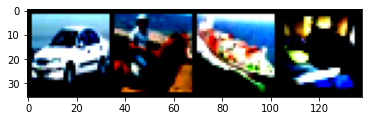

In [4]:
data_iterator = iter(dataloader)
imgs, labels = data_iterator.next()
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.imshow(utils.make_grid(imgs).permute(1,2,0))
for i in range(size):
  print(classes[labels[i]])

* Al ser una clasificacion binaria vamos a tomar dos clases del dataset y solo nos vamos a quedar con los resultados que ingresen dentro de una de las clases reclasificando las etiquetas e instanciando dos nuevos sets de datos y entrenamiento que solo van a tener las imagenes con las clases seleccionanas

In [0]:
class_name = ['automobile', 'cat']
label_map = {1:0, 3:1}

data_set = [(img, label_map[label]) for img, label in full_data_set if label in [1,3]]
validation_set = [(img, label_map[label])for img, label in full_validation_set if label in [1,3]]

In [6]:
img, label = data_set[20]
img.shape

torch.Size([3, 32, 32])

* Una vez tenemos nuestros datasets vamos a entrenar nuestro modelo.
  * Usamos un modelo lineal con valores de entrada de acuerdo al tamaño de nuestras imagenes y su dimension y nuestro valor de salida van a ser 512 'neuronas'
  * Nuestra capa oculta va a utilizar como funcion de activacion Tanh
  * De nuevo llamamos al modelo lineal pero esta vez nuestro valor de entrada van a ser las 512 'neuronas' y nuestro valor de salida va a ser 2 ya que nuestro modelo es binario
  * Agregamos la funcion Softmax debido a que queremos que nuestro resultado sea una probabilidad

In [0]:
model = nn.Sequential(
          nn.Linear(3*32*32,512),
          nn.Tanh(),
          nn.Linear(512,2),
          nn.Softmax(dim=1)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'automobile'

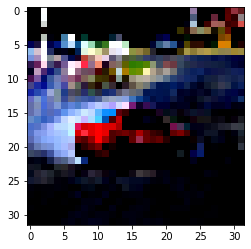

In [8]:
img, label = data_set[20]
plt.imshow(img.permute(1,2,0))
class_name[label]

In [9]:
out = model(img.view(-1).unsqueeze(0))
out

tensor([[0.3978, 0.6022]], grad_fn=<SoftmaxBackward>)

In [10]:
_, index = torch.max(out, dim=1)
print( class_name[label], '->', 'model:', class_name[index])

automobile -> model: cat


* Ya tenemos entrenado el modelo pero podemos mejorar su rendimiento, para esto vamos a usar logaritmos en nuestra funcion softmax
* Ademas debemos implementar la funcion de pérdida con logaritmos

In [0]:
model = nn.Sequential(
          nn.Linear(3*32*32,512),
          nn.Tanh(),
          nn.Linear(512,2),
          nn.LogSoftmax(dim=1)
)
loss_function = nn.NLLLoss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'automobile'

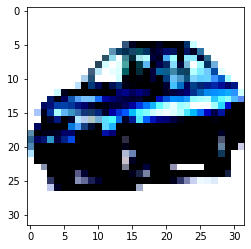

In [12]:
img, label = data_set[30]
plt.imshow(img.permute(1,2,0))
class_name[label]

In [13]:
out = model(img.view(-1).unsqueeze(0))
print(out)

tensor([[-0.6306, -0.7598]], grad_fn=<LogSoftmaxBackward>)


In [14]:
model = nn.Sequential(
          nn.Linear(3*32*32,512),
          nn.Tanh(),
          nn.Linear(512,2),
          nn.LogSoftmax(dim=1)
)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01)
n_epochs = 5

for epoch in range(n_epochs):
  for img, label in data_set:
    out = model(img.view(-1).unsqueeze(0))
    loss = loss_function(out, torch.tensor([label]))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("Epoch: %d, Loss: %f"%(epoch,float(loss)))



Epoch: 0, Loss: 0.007577
Epoch: 1, Loss: 0.036536
Epoch: 2, Loss: 0.229258
Epoch: 3, Loss: 0.010562
Epoch: 4, Loss: 1.018780


In [15]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)
model = nn.Sequential(
          nn.Linear(3*32*32,512),
          nn.Tanh(),
          nn.Linear(512,2),
          nn.LogSoftmax(dim=1)
)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01)
n_epochs = 100

for epoch in range(n_epochs):
  for img, label in train_loader:
    out = model(img.view(img.shape[0],-1))
    loss = loss_function(out, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("Epoch: %d, Loss: %f"%(epoch,float(loss)))

Epoch: 0, Loss: 0.449687
Epoch: 1, Loss: 0.295920
Epoch: 2, Loss: 0.274660
Epoch: 3, Loss: 0.584904
Epoch: 4, Loss: 0.509921
Epoch: 5, Loss: 0.355480
Epoch: 6, Loss: 0.361159
Epoch: 7, Loss: 0.277505
Epoch: 8, Loss: 0.141631
Epoch: 9, Loss: 0.410805
Epoch: 10, Loss: 0.357529
Epoch: 11, Loss: 0.604442
Epoch: 12, Loss: 0.130235
Epoch: 13, Loss: 0.177544
Epoch: 14, Loss: 0.126300
Epoch: 15, Loss: 0.504082
Epoch: 16, Loss: 0.179521
Epoch: 17, Loss: 0.322678
Epoch: 18, Loss: 0.255457
Epoch: 19, Loss: 0.210194
Epoch: 20, Loss: 0.198088
Epoch: 21, Loss: 0.124501
Epoch: 22, Loss: 0.100995
Epoch: 23, Loss: 0.147952
Epoch: 24, Loss: 0.081504
Epoch: 25, Loss: 0.059154
Epoch: 26, Loss: 0.393121
Epoch: 27, Loss: 0.097583
Epoch: 28, Loss: 0.047858
Epoch: 29, Loss: 0.139917
Epoch: 30, Loss: 0.060576
Epoch: 31, Loss: 0.072592
Epoch: 32, Loss: 0.132808
Epoch: 33, Loss: 0.038458
Epoch: 34, Loss: 0.065413
Epoch: 35, Loss: 0.086314
Epoch: 36, Loss: 0.325909
Epoch: 37, Loss: 0.032083
Epoch: 38, Loss: 0.055

In [16]:
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

correct = 0
total = 0

with torch.no_grad():
  for img, labels in validation_loader:
    outputs = model(img.view(img.shape[0],-1))
    _, predicted = torch.max(outputs, dim = 1)
    total += labels.shape[0]
    correct += int((predicted == labels).sum())
  
  print("Accuracy: %f"%(correct/total))

Accuracy: 0.863000


In [17]:
img, label = validation_set[56]
out = model(img.view(-1).unsqueeze(0))
_, index = torch.max(out,dim=1)
out

tensor([[-6.0277e+00, -2.4139e-03]], grad_fn=<LogSoftmaxBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-> cat  model: cat


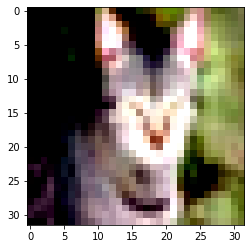

In [18]:
print('->',class_name[label],' model:',class_name[index])
plt.imshow(img.permute(1, 2, 0))
plt.show()

#Mejoras a nuestro modelo

---

* Podemos implementar algunas mejoras que afectarán el rendimiento de nuestro modelo:
 * Primero simplificando algunas operaciones básicas
 * Adicionalmente vamos a aprovechar el efecto combinado de LogSoftmax y NLLLoss y lo reemplazamos por CrossEntropyLoss
 * Además podemos darle mas pasos la secuencia del modelo lineal para mejorar el rendimiento del modelo



In [19]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)
model = nn.Sequential(
          nn.Linear(3072,1028),
          nn.Tanh(),
          nn.Linear(1028,512),
          nn.Tanh(),
          nn.Linear(512,256),
          nn.Tanh(),
          nn.Linear(256,128),
          nn.Tanh(),
          nn.Linear(128,64),
          nn.Tanh(),
          nn.Linear(64,2),
)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01)
n_epochs = 100

for epoch in range(n_epochs):
  for img, label in train_loader:
    out = model(img.view(img.shape[0],-1))
    loss = loss_function(out, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("Epoch: %d, Loss: %f"%(epoch,float(loss)))

Epoch: 0, Loss: 0.500906
Epoch: 1, Loss: 0.443321
Epoch: 2, Loss: 0.452264
Epoch: 3, Loss: 0.352109
Epoch: 4, Loss: 0.575584
Epoch: 5, Loss: 0.277065
Epoch: 6, Loss: 0.362849
Epoch: 7, Loss: 0.192154
Epoch: 8, Loss: 0.627932
Epoch: 9, Loss: 0.261400
Epoch: 10, Loss: 0.216490
Epoch: 11, Loss: 0.154983
Epoch: 12, Loss: 0.490195
Epoch: 13, Loss: 0.280645
Epoch: 14, Loss: 0.267825
Epoch: 15, Loss: 0.154710
Epoch: 16, Loss: 0.438415
Epoch: 17, Loss: 0.353210
Epoch: 18, Loss: 0.132236
Epoch: 19, Loss: 0.054343
Epoch: 20, Loss: 0.239912
Epoch: 21, Loss: 0.124111
Epoch: 22, Loss: 0.165685
Epoch: 23, Loss: 0.036615
Epoch: 24, Loss: 0.047263
Epoch: 25, Loss: 0.134621
Epoch: 26, Loss: 0.093397
Epoch: 27, Loss: 0.363467
Epoch: 28, Loss: 0.039765
Epoch: 29, Loss: 0.019826
Epoch: 30, Loss: 0.009966
Epoch: 31, Loss: 0.062559
Epoch: 32, Loss: 0.006142
Epoch: 33, Loss: 0.014723
Epoch: 34, Loss: 0.032649
Epoch: 35, Loss: 0.324262
Epoch: 36, Loss: 0.008184
Epoch: 37, Loss: 0.004020
Epoch: 38, Loss: 0.011

* Además podemos verificar nuestro modelo con el set de entrenamiento
  * Este resultado nos indica que nuestro modelo tiene Overfitting

In [20]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)

correct = 0
total = 0

with torch.no_grad():
  for img, labels in train_loader:
    outputs = model(img.view(img.shape[0],-1))
    _, predicted = torch.max(outputs, dim = 1)
    total += labels.shape[0]
    correct += int((predicted == labels).sum())
  
  print("Accuracy: %f"%(correct/total))

Accuracy: 1.000000


* En este caso por ejemplo nuestro modelo a pesar de ofrecer un buen rendimiento todavía puede llegar a tener errores de clasificación en problemas complejos

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Correct car:   model: cat


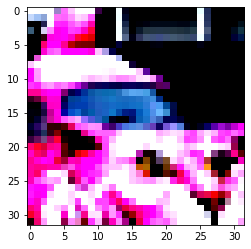

In [22]:
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQEca82WYG_KgO83MP9RYbVODb2Jgk4mFk1dEZtux1K14Ba4mF9&s'
image = request.urlretrieve(url, 'test1.jpg')
img = Image.open(image[0])

preprocess = transforms.Compose([
             transforms.Resize(48),
             transforms.CenterCrop(32),
             transforms.ToTensor(),
             transforms.Normalize(
                 mean=[0.4915, 0.4823, 0.4468],
                 std=[0.2470, 0.2435, 0.2616]
             )
])

img_t = preprocess(img)
out = model(img_t.view(-1).unsqueeze(0))
_, index = torch.max(out,dim=1)
print('Correct car: ',' model:',class_name[index])
plt.imshow(img_t.permute(1,2,0))